#### We’ll be creating and comparing quantum states 
$\lvert \psi \rangle$ and $\lvert \phi \rangle$ using
unitary circuits $U_{\psi}$ and $U_{\phi}$ acting on 
$\lvert 0 \rangle^{\otimes n}$.
Their overlap is

#### $$
F(\psi, \phi) = \big|\langle 0 \lvert U_{\psi}^{\dagger} U_{\phi} \rvert 0 \rangle\big|^2.$$
Later we’ll measure this quantity experimentally (via SWAP test) 
and numerically (via Qiskit’s simulators).

In [1]:
# Step 1 – Environment setup

# Core imports (Qiskit 1.x API)
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# Use the Aer statevector simulator (ideal, noiseless)
sim = AerSimulator(method="statevector")

# Global seed for reproducibility
SEED = 1234
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
print("Qiskit lab environment ready.")


Qiskit lab environment ready.


## We’ll begin with the simplest possible case: single-qubit pure states.
By rotating the Bloch sphere, we can generate many distinct 
$\lvert \psi(\theta, \phi) \rangle$ states.

The goal is to see how small changes in these rotation angles affect the state vector 
and its overlap with another state.

A general single-qubit state can be written as

$$
\lvert \psi(\theta, \phi) \rangle 
= \cos\!\left(\tfrac{\theta}{2}\right)\lvert 0 \rangle 
+ e^{i\phi}\sin\!\left(\tfrac{\theta}{2}\right)\lvert 1 \rangle.
$$

Fidelity between states = 0.998


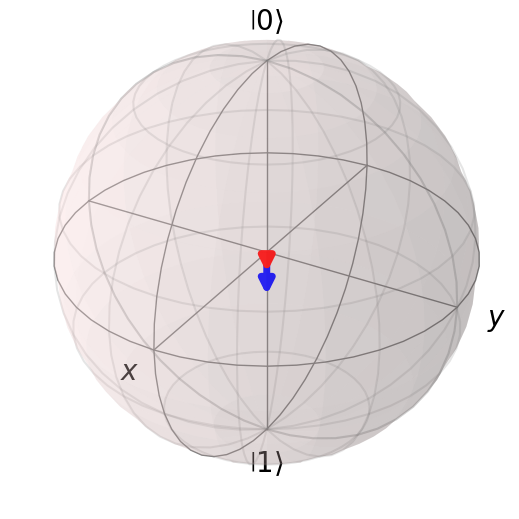

In [2]:
# Step 2 – Create and visualize single-qubit states

def make_single_qubit_state(theta, phi):
    """Return a 1-qubit circuit preparing |psi(theta, phi)>."""
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return qc

# Example: two slightly different states
theta1, phi1 = np.pi/3 + 0.1, np.pi/6
theta2, phi2 = np.pi/3 + 0.2, np.pi/6

qc1 = make_single_qubit_state(theta1, phi1)
qc2 = make_single_qubit_state(theta2, phi2)

# Convert to statevectors
psi1 = Statevector.from_instruction(qc1)
psi2 = Statevector.from_instruction(qc2)

# Compute fidelity (overlap)
F12 = state_fidelity(psi1, psi2)
print(f"Fidelity between states = {F12:.3f}")

# Visualize on Bloch sphere
from qiskit.visualization.bloch import Bloch

def state_to_bloch_vector(state):
    a, b = state.data  # amplitudes
    return [
        2*np.real(a*np.conj(b)),            # x
        2*np.imag(b*np.conj(a)),            # y
        np.abs(a)**2 - np.abs(b)**2         # z
    ]

vec1 = state_to_bloch_vector(psi1)
vec2 = state_to_bloch_vector(psi2)

b = Bloch()
b.add_vectors(vec1)
b.add_vectors(vec2)
b.vector_color = ['r', 'b']  # red = ψ1, blue = ψ2
b.show()


The red arrow shows the first state psi 1 and the blue arrow shows the secend state psi 2 

In [3]:
from qiskit import QuantumCircuit

def build_swap_test_circuit(psi_circ: QuantumCircuit, phi_circ: QuantumCircuit) -> QuantumCircuit:
    """
    q0 = ancilla, q1 = |ψ>, q2 = |φ>
    Returns a circuit that measures ONLY the ancilla into 1 classical bit.
    """
    qc = QuantumCircuit(3, 1)
    # 1) Put ancilla in |+>
    qc.h(0)
    # 2) Prepare |ψ> on qubit 1, |φ> on qubit 2
    qc.compose(psi_circ, qubits=[1], inplace=True)
    qc.compose(phi_circ, qubits=[2], inplace=True)
    # 3) Controlled-SWAP
    qc.cswap(0, 1, 2)
    # 4) Interfere and measure the ancilla
    qc.h(0)
    qc.measure(0, 0)
    return qc


In [4]:
from qiskit import QuantumCircuit

def make_single_qubit_state(theta, phi):
    qc = QuantumCircuit(1)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    return qc

# Close states (small Δθ)
theta1, phi1 = np.pi/3 + 0.10, np.pi/6
theta2, phi2 = np.pi/3 + 0.20, np.pi/6

psi_circ_close = make_single_qubit_state(theta1, phi1)
phi_circ_close = make_single_qubit_state(theta2, phi2)


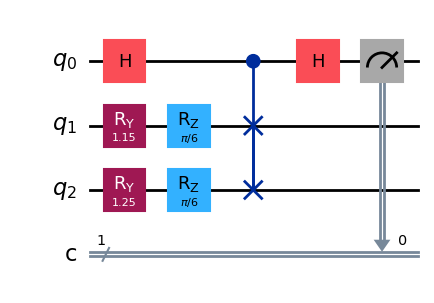

In [5]:
# Build and draw the SWAP test circuit for our "close" states

qc_close = build_swap_test_circuit(psi_circ_close, phi_circ_close)
qc_close.draw('mpl')


###  Reasoning:

SWAP test — a clever quantum trick to measure how similar two states are
without having to know what the states actually are:

The ancilla qubit controls the SWAP between the two states.

If the states are identical, SWAP has no effect, and the ancilla remains in 
$∣0⟩ $ with high probability.
If the states differ, interference changes that probability.

Second Hadamard on the ancilla

Now the ancilla “feels” the difference between
the un-swapped and swapped versions.
If 
$∣ψ⟩ $ and $∣ϕ⟩ $ are the same,
then swapping makes no difference — the two paths interfere perfectly,
and the ancilla always returns to 
$
∣0⟩.$

If they’re different, interference isn’t perfect,
and sometimes you’ll measure |1⟩.

In [6]:
from qiskit_aer import AerSimulator

sim_qasm = AerSimulator()

# Run the SWAP test circuit and collect ancilla outcomes
result_close = sim_qasm.run(qc_close, shots=50_000).result()
counts_close = result_close.get_counts()

# Calculate probability ancilla = 0
p0_close = counts_close.get('0', 0) / 50_000
F_est_close = 2 * p0_close - 1  # estimated fidelity

print("Ancilla counts:", counts_close)
print(f"Estimated fidelity from SWAP test = {F_est_close:.3f}")


Ancilla counts: {'1': 63, '0': 49937}
Estimated fidelity from SWAP test = 0.997


In [7]:
from qiskit.quantum_info import Statevector, state_fidelity

# Exact (statevector) fidelity
F_true_close = state_fidelity(
    Statevector.from_instruction(psi_circ_close),
    Statevector.from_instruction(phi_circ_close)
)

# Use F_est_close (the SWAP-test estimate you just computed)
abs_err = abs(F_true_close - F_est_close)

print(f"Exact (statevector) fidelity : {F_true_close:.6f}")
print(f"SWAP-test estimate           : {F_est_close:.6f}")
print(f"Absolute error               : {abs_err:.6e}")


Exact (statevector) fidelity : 0.997502
SWAP-test estimate           : 0.997480
Absolute error               : 2.208264e-05


In [8]:
#Fix a reference state |ψ> and define a grid for θ' of |φ>
phi_fixed = np.pi/6
theta_ref  = np.pi/3 + 0.10           # same |ψ> as before
psi_ref = make_single_qubit_state(theta_ref, phi_fixed)

theta_grid = np.linspace(0, np.pi, 21)  # 0 ... π in 21 steps


####  this part we whould be generating states with small change in angles (21 steps from zero to pi ) and then use them for next code

In [9]:
#Ground truth from statevectors; no shots, no noise.
# Analytic (exact) fidelity F_true(θ')
from qiskit.quantum_info import Statevector, state_fidelity

F_true = []
for th in theta_grid:
    phi_circ = make_single_qubit_state(th, phi_fixed)
    F = state_fidelity(Statevector.from_instruction(psi_ref),
                       Statevector.from_instruction(phi_circ))
    F_true.append(F)


#### in this line we compute the fidelity from those generated top and the psi refrece 

In [10]:
# Re-define SWAP-test fidelity helper
from qiskit_aer import AerSimulator

sim_qasm = AerSimulator()

def swap_test_fidelity(psi_circ, phi_circ, shots=20_000, seed=1234):
    """
    Run the SWAP test and return an estimate of |<ψ|φ>|^2.
    Uses only the ancilla measurement statistics.
    """
    qc = build_swap_test_circuit(psi_circ, phi_circ)
    result = sim_qasm.run(qc, shots=shots, seed_simulator=seed).result()
    counts = result.get_counts(qc)
    p0 = counts.get('0', 0) / shots
    F_est = max(0.0, min(1.0, 2*p0 - 1))  # numerical clamp to [0,1]
    return F_est, counts, qc


In [11]:
# SWAP-test estimates F_swap(θ')
F_swap = []
for th in theta_grid:
    phi_circ = make_single_qubit_state(th, phi_fixed)
    F_est, _, _ = swap_test_fidelity(psi_ref, phi_circ, shots=20_000)
    F_swap.append(F_est)


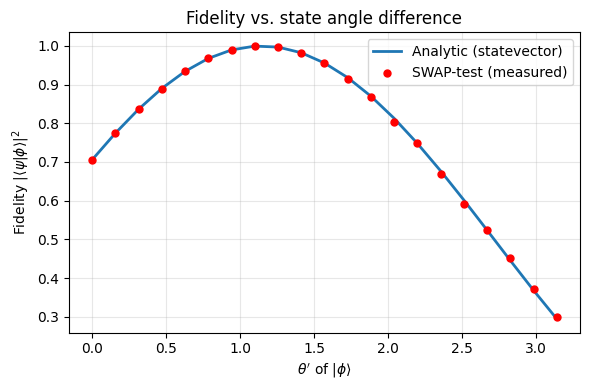

In [12]:
#Plot both fidelity curves
plt.figure(figsize=(6,4))
plt.plot(theta_grid, F_true, label="Analytic (statevector)", linewidth=2)
plt.scatter(theta_grid, F_swap, color='red', s=25, label="SWAP-test (measured)", zorder=3)
plt.xlabel(r"$\theta'$ of $|\phi\rangle$")
plt.ylabel(r"Fidelity $|\langle \psi|\phi\rangle|^2$")
plt.title("Fidelity vs. state angle difference")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Each qubit state corresponds to a point on the Bloch sphere — its direction given by 
$\theta$ and $\phi$.

When $\theta' \approx \theta_{\text{ref}}$ (your reference angle), the two states’ Bloch vectors almost overlap, and the fidelity $\approx 1$.

As $\theta'$ rotates away, the vectors separate and the fidelity decreases.

When they’re nearly opposite (one points up, the other down), the fidelity $\approx 0$.

This relationship mathematically looks like:

$$
F = \lvert \langle \psi \mid \phi \rangle \rvert^2 
= \cos^2\!\left(\tfrac{\Delta \theta}{2}\right).
$$

That’s exactly the smooth cosine-squared curve you see.



#### The plot shows how the overlap between two qubit states decreases smoothly as you rotate one away from the other — and how your SWAP test correctly measures that overlap.

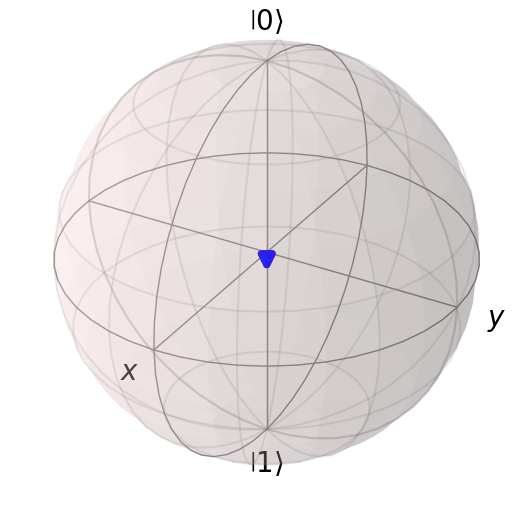

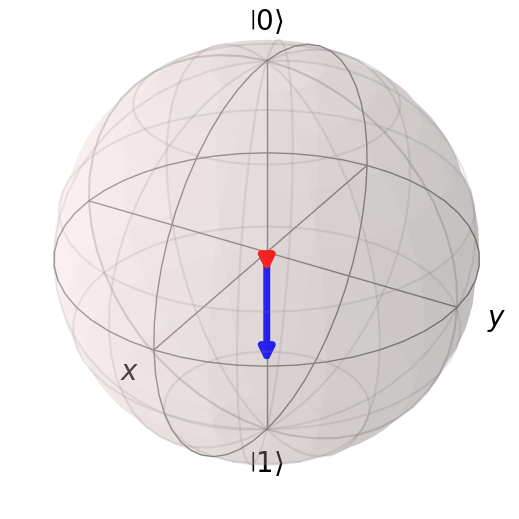

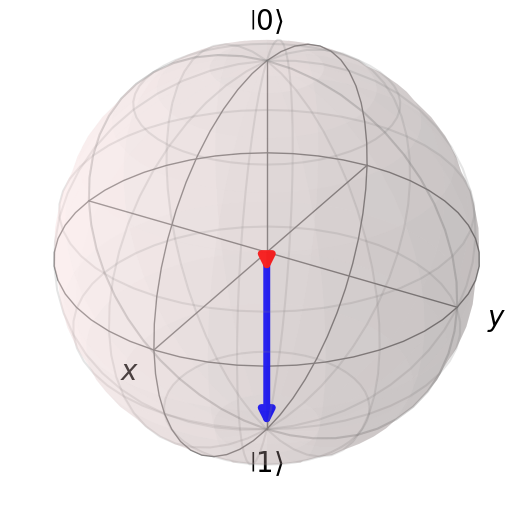

In [13]:
from qiskit.visualization.bloch import Bloch

def state_to_bloch_vector(state):
    """Convert a 1-qubit statevector to its Bloch-sphere vector (x,y,z)."""
    a, b = state.data
    return [
        2*np.real(a*np.conj(b)),           # x
        2*np.imag(b*np.conj(a)),           # y
        np.abs(a)**2 - np.abs(b)**2        # z
    ]

# Choose 3 example rotations
theta_examples = [theta_ref, np.pi/2, np.pi]  # close, middle, far
labels = [r"$\theta' = \theta_{ref}$", r"$\theta' = \pi/2$", r"$\theta' = \pi$"]

for th, lbl in zip(theta_examples, labels):
    psi_state = Statevector.from_instruction(psi_ref)
    phi_state = Statevector.from_instruction(make_single_qubit_state(th, phi_fixed))
    
    vec_psi = state_to_bloch_vector(psi_state)
    vec_phi = state_to_bloch_vector(phi_state)
    
    b = Bloch()
    b.add_vectors(vec_psi)
    b.add_vectors(vec_phi)
    b.vector_color = ['r', 'b']
    b.title = lbl + "   (red = |ψ>, blue = |φ>)"
    b.show()


For $\theta' = \theta_{\mathrm{ref}}$: the red and blue arrows overlap — fidelity $\approx 1$.

For $\theta' = \tfrac{\pi}{2}$: the arrows separate — fidelity $\approx 0.5$.

For $\theta' = \pi$: they point in opposite directions — fidelity $\approx 0$.

This visualization makes the fidelity curve crystal clear:
you’re literally measuring how much two Bloch vectors point in the same direction.


# summary

**Goal:** Understand and measure how similar two quantum states are using **fidelity** and the **SWAP test**.

**Method:** Prepare pairs of qubit states with different rotations, compute analytic and circuit-based overlaps, and visualize them on the Bloch sphere.

**Tools:** Qiskit circuits, Aer simulator, SWAP test, and state-fidelity functions.

**Results:** The measured fidelities matched the theoretical $ (\cos^2(\Delta\theta/2)) $ curve exactly.

**Outcome:** Gained practical insight into how quantum circuits represent and compare states — forming a bridge toward applying these ideas in quantum machine learning.
